In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot
import ECGHandle
import torch
import torch.utils.data as Data
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter


def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [2]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = "cpu"

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_torch(2023)
data_root = '/workspace/data/Preprocess_HTN/datas_/'
ALL_data = pd.read_csv(data_root+'/All_data_handled_ID_range_age_IDimputate.csv',low_memory=False)
ALL_data = ECGHandle.change_label(ALL_data)
ALL_data = ECGHandle.filter_ID(ALL_data)
ALL_data = ECGHandle.filter_QC(ALL_data)
ALL_data = ECGHandle.filter_ages(ALL_data,18)
ALL_data = ECGHandle.filter_departmentORlabel(ALL_data,'外科')
ALL_data = ECGHandle.correct_label(ALL_data)
ALL_data = ECGHandle.correct_age(ALL_data)
ALL_data = ECGHandle.filter_diagnose(ALL_data,'起搏')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'房颤')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左束支传导阻滞')
ALL_data = ECGHandle.filter_diagnose(ALL_data,'左前分支阻滞')
# ALL_data = ECGHandle.filter_diagnose(ALL_data,'阻滞')
# ALL_data = ECGHandle.remove_duplicated(ALL_data)
ALL_data = ALL_data.rename(columns={'住院号':'ID','年龄':'age','性别':'gender','姓名':'name'}) 
ALL_data_buffer = ALL_data.copy()
seed_torch(2023)
ALL_data_buffer = ALL_data_buffer.sample(frac=1).reset_index(drop=True) #打乱顺序
# all_dataset = ECGHandle.ECG_Dataset(data_root,ALL_data_buffer,preprocess = True)
####################################################################随机选取test
test_df,tv_df = Pair_ID(ALL_data,0.2,Range_max=15,pair_num=1)
test_dataset = ECGHandle.ECG_Dataset(data_root,test_df,preprocess = True)
Models_path = 'model/20230302_080241/20230302_080241/parameter_EarlyStoping_3.pt'
save_root = Models_path[:-3]+'/'
layervalue_root = save_root+'/layervalue/'



            orginal   removed diagnose NaN
   nums      200082          199997       
              HTN             NHTN        
   nums       3273           196724       


            orginal      removed ID NaN   
   nums      199997          199995       
              HTN             NHTN        
   nums       3273           196722       


            orginal            QC         
   nums      199995          72845        
              HTN             NHTN        
   nums       1497           71348        


            orginal      filtered ages    
   nums      72845           69819        
              HTN             NHTN        
   nums       1477           68342        


            orginal   filtered department 
   nums      69819           15344        
              HTN             NHTN        
   nums       1477           13867        


     reset num:       10  
  ERR labels num:     27  
            orginal      correct label    
   nums      15344           15

In [3]:
Models_path = '/workspace/data/Interpretable_HTN/model/20230307_144157/20230307_144157/BestF1_0.pt'
NET = [Net.MLBFNet_GUR_o(True,True,True,2,Dropout_rate=0.3), ] # type: ignore
criterion = torch.nn.CrossEntropyLoss()
testmodel = NET[0].to(DEVICE)
testmodel.load_state_dict(torch.load(Models_path))

<All keys matched successfully>

In [4]:
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)  
y_true,y_pred,y_out,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 验证模型

In [5]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

In [6]:
def ROC(label, y_prob):
    """
    Receiver_Operating_Characteristic, ROC
    :param label: (n, )
    :param y_prob: (n, )
    :return: fpr, tpr, roc_auc, optimal_th, optimal_point
    """
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(label, y_prob)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point

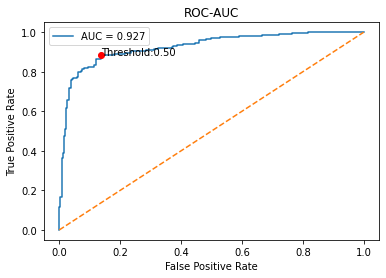

In [36]:
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(y_true,((np.array(y_out))[:,1]))

plt.figure(1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [37]:
roc_auc

0.926592117632203

In [38]:
optimal_th

0.4999432861804962

In [28]:
y_pred = ((np.array(y_out))[:,1])
y_pred[y_pred>optimal_th] =  1
y_pred[y_pred<=optimal_th] =  0

In [29]:
CM = confusion_matrix(y_true,y_pred)
CM

array([[227,  36],
       [ 32, 239]])

In [30]:
TP = CM[1,1]
TN = CM[0,0]
FP = CM[0,1]
FN = CM[1,0]

In [31]:
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
specificity = TN/(TN+FP)
FPR = FP/(TP+FP)

In [32]:
specificity

0.8631178707224335

In [33]:
Recall

0.8819188191881919

In [34]:
Precision

0.8690909090909091

In [35]:
roc_auc

0.926592117632203

In [17]:
precision, recall, thresholds = sklearn.metrics .precision_recall_curve(y_true, np.array(y_out)[:,1])

In [49]:
def PR(label, y_prob):
    """
    Receiver_Operating_Characteristic, ROC
    :param label: (n, )
    :param y_prob: (n, )
    :return: fpr, tpr, roc_auc, optimal_th, optimal_point
    """
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(label, y_prob)
    y = np.abs(2*(precision*recall)/(precision + recall))
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = thresholds[Youden_index]  
    opiont = [precision[Youden_index],recall[Youden_index]]
    disp = sklearn.metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
    return precision, recall, disp, optimal_threshold,opiont

In [54]:
precision, recall, disp, optimal_th, optimal_point = PR(y_true, np.array(y_out)[:,1])


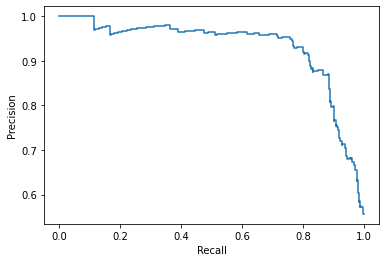

In [55]:
disp.plot()

In [56]:
optimal_th

0.4999432861804962

In [57]:
optimal_point

[0.8695652173913043, 0.8856088560885609]

In [64]:
y_pred = ((np.array(y_out))[:,1])
y_pred[y_pred>=optimal_th] =  1
y_pred[y_pred<optimal_th] =  0
CM = confusion_matrix(y_true,y_pred)
CM

array([[227,  36],
       [ 31, 240]])

In [65]:
TP = CM[1,1]
TN = CM[0,0]
FP = CM[0,1]
FN = CM[1,0]

In [66]:
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
specificity = TN/(TN+FP)
FPR = FP/(TP+FP)

In [67]:
Precision

0.8695652173913043

In [68]:
Recall

0.8856088560885609

In [63]:
specificity

0.8631178707224335

In [69]:
np.abs(2*(Precision*Recall)/(Precision + Recall))

0.8775137111517367